
# Cancer Detection in Blood

![Cancer Cell Treatment](https://blogs.biomedcentral.com/on-medicine/wp-content/uploads/sites/6/2017/08/Cancer-cell-treatment.jpg)

The microscopic blood cell dataset for leukemia detection consists of high-resolution images essential for automated diagnostic systems. Each image captures detailed cellular morphology under standardized conditions, focusing on both normal and abnormal blood cells. This dataset is crucial for addressing the problem of detecting cancer in blood, paving the way for future advancements in medical diagnostics.


## **Uploading Main Packages**

To begin our workflow, we need to upload the necessary datasets and import the main packages required for our analysis and model building. This includes libraries for data manipulation, visualization, machine learning, and deep learning.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import ParameterGrid
import warnings
from tensorflow.keras.layers import GlobalAveragePooling2D
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random

warnings.filterwarnings('ignore')

In [2]:
path = "/kaggle/input/blood-cell-images-for-cancer-detection"
print(os.listdir(path))

['monocyte', 'basophil', 'erythroblast', 'seg_neutrophil', 'myeloblast']


## **Random Image Verification**

To ensure that we have correctly loaded and processed the images, let's pick a random image from our dataset and display it. This step helps us verify that the images are being read and handled correctly.

(363, 360, 3)


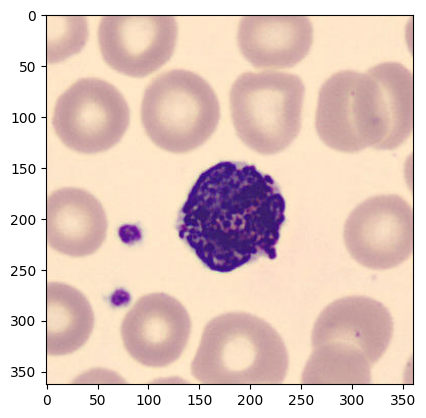

In [3]:
image_path = os.path.join(path, "basophil", "BA_100102.jpg")

try:
  img = mpimg.imread(image_path)
  plt.imshow(img)
  print(img.shape)
  plt.show()

except FileNotFoundError:
  print(f"Image file not found at: {image_path}")
  print("List of files in the basophil directory:")
  !ls basophil

## **Data Preparation**

To handle the data more efficiently, we will convert it into a simple format with two columns: one for the image path and another for the target label. This will streamline our data processing and make it easier to work with in subsequent steps.

In [4]:
data = []
directories = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

for directory in directories:
  directory_path = os.path.join(path, directory)
  for filename in os.listdir(directory_path):
    if filename.endswith(('.jpg')):
      image_path = os.path.join(directory_path, filename)
      data.append({'Image': image_path, 'Target': directory})

df = pd.DataFrame(data)
print(df.shape)

(5000, 2)


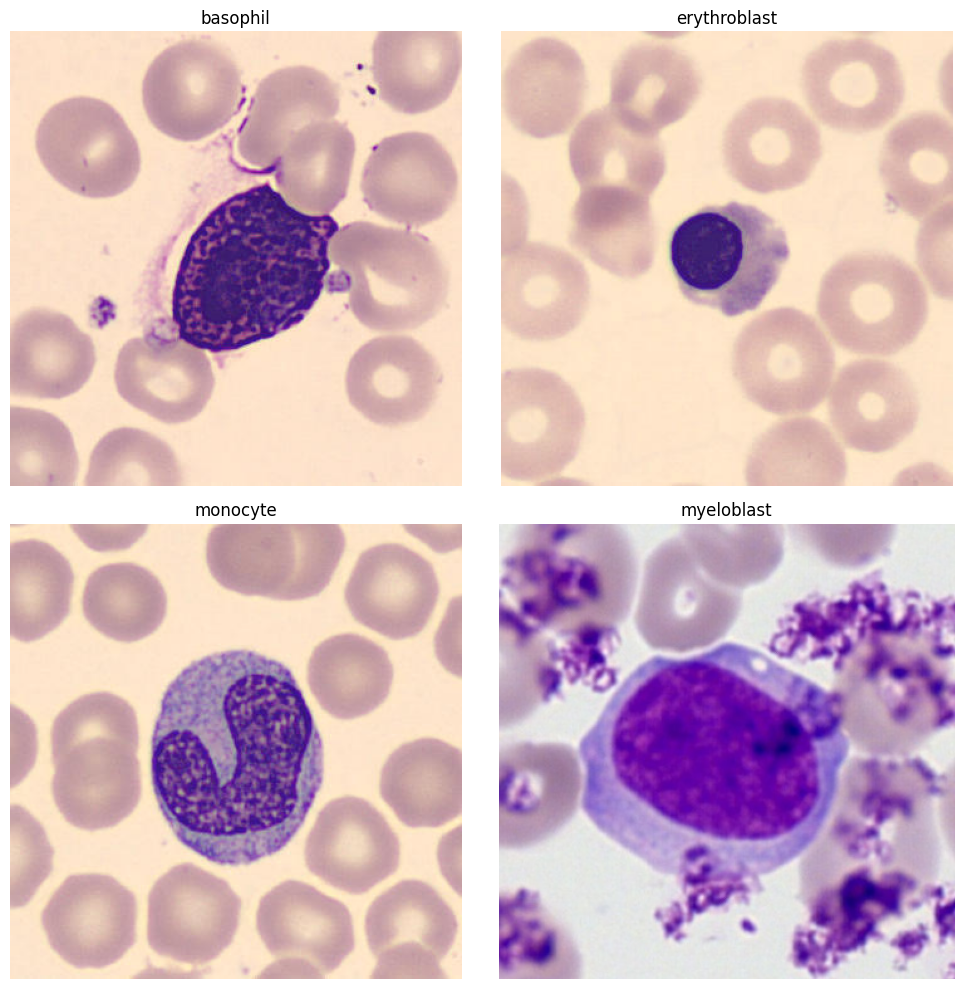

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

unique_targets = df['Target'].unique()
num_unique_targets = len(unique_targets)

for i in range(min(4, num_unique_targets)):
    target = unique_targets[i]
    image_path = df[df['Target'] == target]['Image'].iloc[0]
    try:
        img = mpimg.imread(image_path)
        axes[i].imshow(img)
        axes[i].set_title(target)
        axes[i].axis('off')  # Hide axis ticks and labels
    except FileNotFoundError:
        print(f"Image file not found at: {image_path}")
        axes[i].set_title(f"Image not found for {target}")

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()
plt.show()

<center>

| Blood Cell Type | Main Purpose | Cancer Risk (%) |
|---|---|---|
| Basophil | Triggers allergic reactions, releases histamine & heparin | ~5% (in CML cases) |
| Erythroblast | Develops into red blood cells (RBCs), produces hemoglobin | ~10-15% (PV progressing to leukemia) |
| Monocyte | Becomes macrophages, engulfs pathogens, helps in immune defense | ~15-30% (CMML progressing to AML) |
| Myeloblast | Immature white blood cell precursor, develops into granulocytes | ~100% (AML originates from myeloblasts) |
| Segmented Neutrophil | First-line defense against bacterial infections, kills pathogens | ~10-40% (high-risk MDS progressing to AML) |

 Some blood cells can turn into cancer if they grow abnormally. Myeloblasts have the highest risk (100%) because they can directly cause leukemia. Monocytes (15-30%) and erythroblasts (10-15%) have a moderate risk, while basophils (~5%) and neutrophils (10-40%) can sometimes indicate cancer but are less likely to turn cancerous themselves. </center>

## **Modeling**

 We will create, train, and evaluate a convolutional neural network (CNN) to classify the different types of blood cells. This section will cover the model architecture, training process, and evaluation metrics to assess the model's performance.

In [6]:
dfs = {}
# Iterate through unique targets
for target in df['Target'].unique():
  # Filter DataFrame for the current target
  df_target = df[df['Target'] == target]
  # Split into train, validation, and test sets
  train_df, temp_df = train_test_split(df_target, train_size=700, random_state=42, shuffle=True)
  val_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=42, shuffle=True)

  # Store the DataFrames in the dictionary
  dfs[target] = {'train': train_df, 'val': val_df, 'test': test_df}

train_df = pd.concat([dfs[target]['train'] for target in dfs])
val_df = pd.concat([dfs[target]['val'] for target in dfs])
test_df = pd.concat([dfs[target]['test'] for target in dfs])

# Print the shapes of the resulting DataFrames
print("Train DataFrame shape:", train_df.shape)
print("Validation DataFrame shape:", val_df.shape)
print("Test DataFrame shape:", test_df.shape)

Train DataFrame shape: (3500, 2)
Validation DataFrame shape: (750, 2)
Test DataFrame shape: (750, 2)


In [7]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
)


train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image",
    y_col="Target",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="Image",
    y_col="Target",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image",
    y_col="Target",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale'
)


Found 3500 validated image filenames belonging to 5 classes.
Found 750 validated image filenames belonging to 5 classes.
Found 750 validated image filenames belonging to 5 classes.


(128, 128, 1)


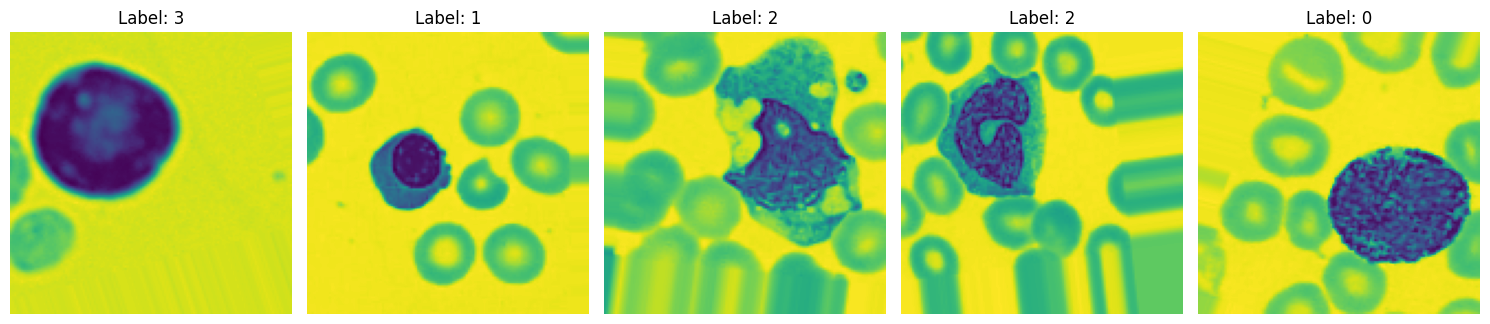

In [8]:
# Get a batch of images and labels from the training generator
images, labels = next(train_generator)

# Number of images to display
num_images = min(len(images), 5)

# Create a figure and subplots
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Iterate over the images and display them
for i in range(num_images):
    axes[i].imshow(images[i])
    axes[i].set_title(f"Label: {labels[i].argmax()}") # Display predicted class
    axes[i].axis('off')

print(images[0].shape)
plt.tight_layout()
plt.show()

## **Building up our CNN**

In this section, we will define and compile our Convolutional Neural Network (CNN) model. The model will be designed to classify different types of blood cells based on the images provided. We will also set up the training process, including data augmentation, and define the evaluation metrics to assess the model's performance.

In [9]:
def create_model(input_shape=(128, 128, 1)):
    """
    Create a CNN model with fixed architecture

    Args:
        input_shape: Shape of input images, default (128, 128, 1)

    Returns:
        Compiled Keras model
    """
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Flatten and dense layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_model(model, train_generator, val_generator, epochs=30):
    """
    Train the model with early stopping and learning rate reduction

    Args:
        model: Compiled Keras model
        train_generator: Training data generator
        val_generator: Validation data generator
        epochs: Maximum number of epochs to train

    Returns:
        Training history and trained model
    """
    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        )
    ]

    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )

    return history, model

def plot_training_history(history):
    """
    Plot training history including accuracy and loss curves

    Args:
        history: Keras training history object
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss plot
    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    """
    Plot confusion matrix with class labels

    Args:
        y_true: True labels
        y_pred: Predicted labels
    """
    # Define class labels
    class_labels = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

def print_classification_metrics(y_true, y_pred):
    """
    Print classification report with class labels

    Args:
        y_true: True labels
        y_pred: Predicted labels
    """
    class_labels = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

    report = classification_report(
        y_true,
        y_pred,
        target_names=class_labels,
        digits=4
    )
    print("\nClassification Report:")
    print(report)

def evaluate_model(model, test_generator):
    """
    Evaluate the model on test data

    Args:
        model: Trained Keras model
        test_generator: Test data generator

    Returns:
        Test loss, accuracy, and predicted classes
    """
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)

    # Get predictions
    predictions = model.predict(test_generator)
    predicted_classes = predictions.argmax(axis=1)

    return test_loss, test_accuracy, predicted_classes

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

# Define parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 30

# Create and compile model
print("Creating model...")
model = create_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
model.summary()

# Train model
print("\nTraining model...")
history, trained_model = train_model(
    model,
    train_generator,
    val_generator,
    epochs=EPOCHS
)

# Evaluate model
print("\nEvaluating model...")
test_loss, test_accuracy, predictions = evaluate_model(trained_model, test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')


Creating model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,518,661 (24.87 MB)

 Trainable params: 6,517,701 (24.86 MB)

 Non-trainable params: 960 (3.75 KB)


Training model...
Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 43s 300ms/step - accuracy: 0.5752 - loss: 1.4723 - val_accuracy: 0.2000 - val_loss: 8.9722 - learning_rate: 0.0010
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.8758 - loss: 0.3786 - val_accuracy: 0.2000 - val_loss: 8.4231 - learning_rate: 0.0010
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.9106 - loss: 0.2963 - val_accuracy: 0.2000 - val_loss: 7.9200 - learning_rate: 0.0010
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9192 - loss: 0.2460 - val_accuracy: 0.2013 - val_loss: 6.0128 - learning_rate: 0.0010
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 0.9277 - loss: 0.2156 - val_accuracy: 0.3013 - val_loss: 2.4964 - learning_rate: 0.0010
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - accuracy: 0.9319 - loss: 0.2034 - val_accuracy: 0.5840 - val_loss: 2.9608 - learning_rate: 0.0010
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/s


Plotting results...


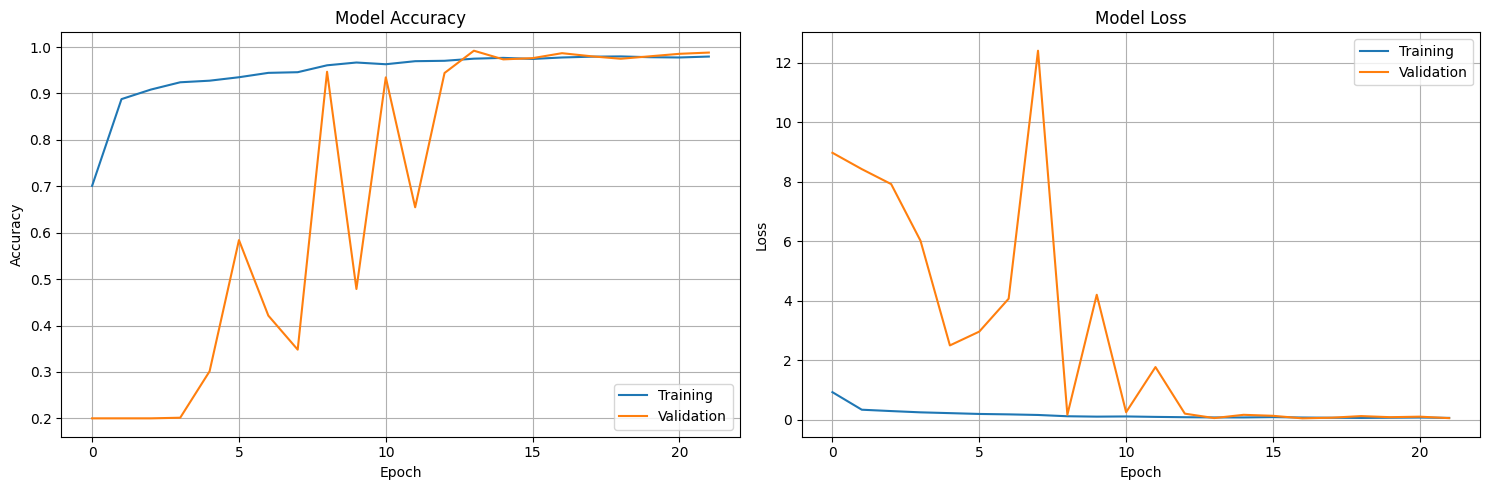

In [11]:
# Plot results
print("\nPlotting results...")
plot_training_history(history)

## **Model Evaluation and Analysis**

In this section, we will evaluate the performance of our trained CNN model. We will analyze the accuracy, loss, and confusion matrix to understand how well the model predicts different types of blood cells. 

Given that myeloblasts have the highest cancer risk (100%), we are particularly interested in the model's ability to accurately identify myeloblasts. We will examine the confusion matrix and classification report to see if the model can predict myeloblasts with high precision and recall.

Let's proceed with the evaluation and see if the model meets our expectations.

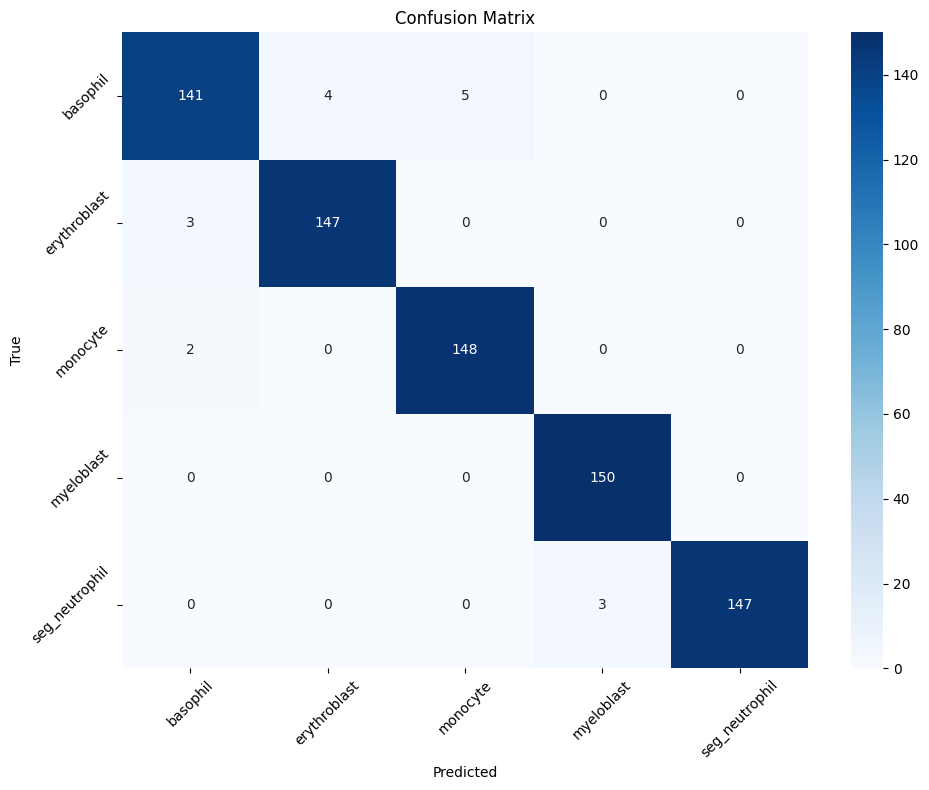


Classification Report:
                precision    recall  f1-score   support

      basophil     0.9658    0.9400    0.9527       150
  erythroblast     0.9735    0.9800    0.9767       150
      monocyte     0.9673    0.9867    0.9769       150
    myeloblast     0.9804    1.0000    0.9901       150
seg_neutrophil     1.0000    0.9800    0.9899       150

      accuracy                         0.9773       750
     macro avg     0.9774    0.9773    0.9773       750
  weighted avg     0.9774    0.9773    0.9773       750



In [12]:
# Get true labels from test generator
y_true = test_generator.classes

# Plot confusion matrix
plot_confusion_matrix(y_true, predictions)
print_classification_metrics(y_true, predictions)

## **Perfect Summary of our Target**

That's more than perfect! We could target that recall fitting the idea of the user by the model and actual life. This ensures that if a user has myeloblasts, the model accurately identifies it, preventing the scenario where the model underestimates the severity by predicting a less dangerous condition. 

Enhancing this aspect in the medical field can be achieved by acquiring more data and implementing additional actions. This will improve the model's precision and recall, particularly for high-risk conditions like myeloblasts, ultimately leading to better diagnostic accuracy and patient outcomes.

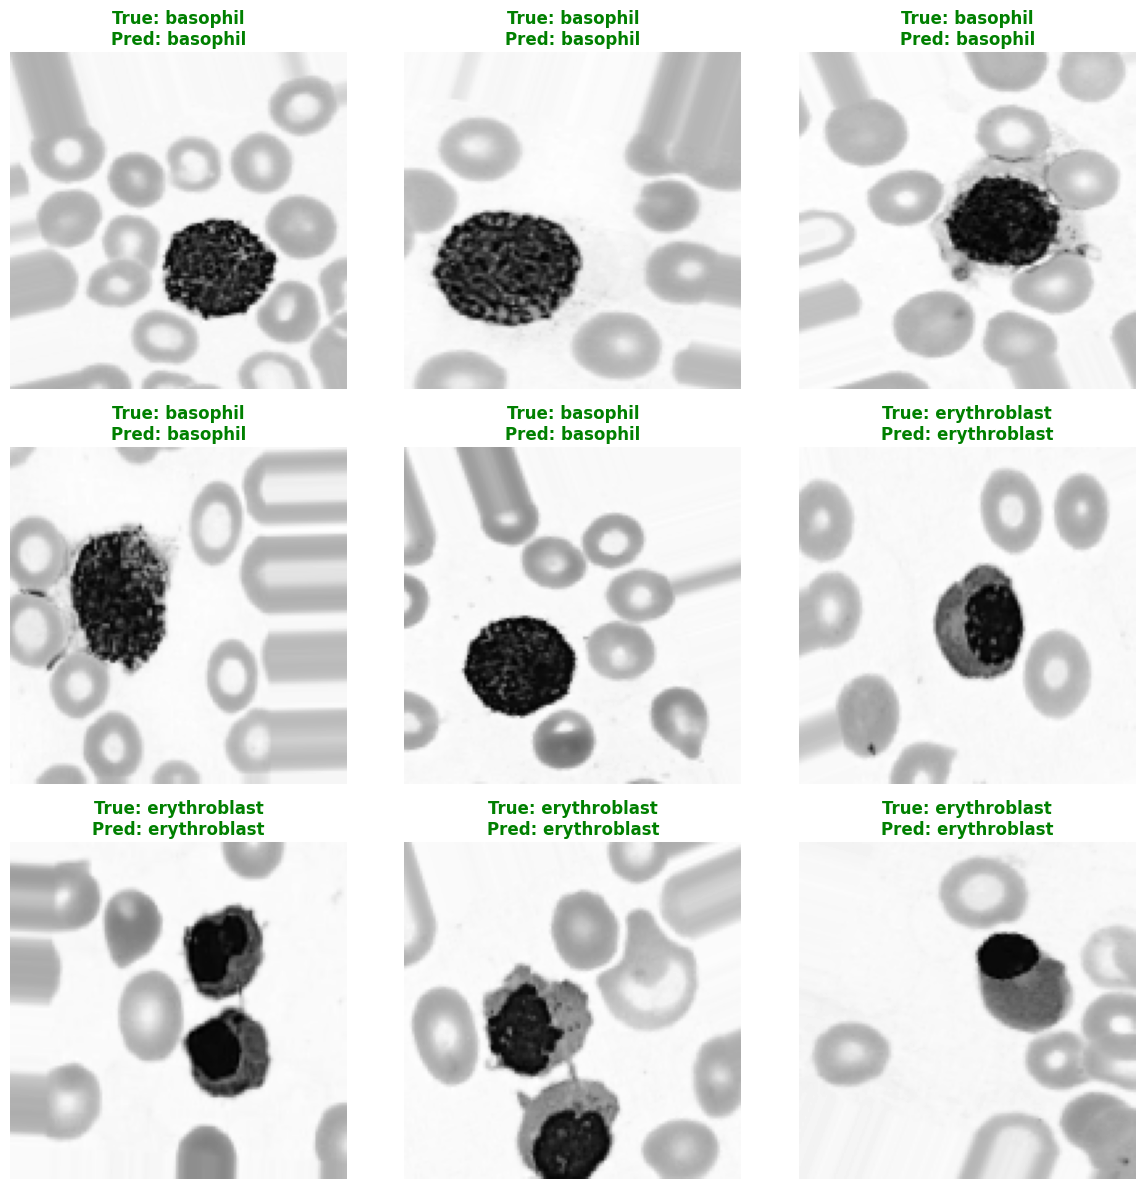

In [13]:

def show_random_predictions(model, test_generator):
    """
    Display 3x3 grid of random test images with predictions.
    """
    # Labels for our classes
    labels = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']
    
    # Create 3x3 subplot
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    
    for i in range(3):
        for j in range(3):
            # Get a random batch and image from test generator
            batch_x, batch_y = next(test_generator)  
            idx = random.randint(0, len(batch_x)-1)
            img = batch_x[idx]
            true_label = np.argmax(batch_y[idx])
            
            # Get prediction
            pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
            pred_label = np.argmax(pred)
            
            # Determine text color (Green if correct, Red if wrong)
            color = 'green' if true_label == pred_label else 'red'
            
            # Plot image
            axes[i, j].imshow(np.squeeze(img), cmap='gray')
            axes[i, j].set_title(
                f'True: {labels[true_label]}\nPred: {labels[pred_label]}',
                color=color, fontsize=12, fontweight='bold'
            )
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Use it with your model:
show_random_predictions(trained_model, test_generator)